In [30]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.preprocessing import LabelEncoder 
# for keras
from classification_models.keras import Classifiers

# for tensorflow keras
from classification_models.tfkeras import Classifiers
%matplotlib inline

In [31]:
IMG_WIDTH=300
IMG_HEIGHT=300
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)

In [32]:
train_files = glob.glob('D:\deepfake_detection\datasets\\frames\*')

validation_files = glob.glob('D:\deepfake_detection\datasets\\validation_data\*')

test_files = glob.glob('D:\deepfake_detection\datasets\\testing_data\*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)

In [33]:
len(train_files), len(validation_files), len(test_files)

(5473, 207, 208)

## For Labels

In [34]:
labels = pd.read_csv('D:\deepfake_detection\datasets\out.csv', index_col=0)
# labels.loc['aagfhgtpmv_1.jpg'][0]

In [35]:
labels.head(2)

,label
Images,
aagfhgtpmv_1.jpg,FAKE
aagfhgtpmv_10.jpg,FAKE


In [36]:
train_labels = []
train_real = []
train_fake = []
for img in train_files:
    file_name = os.path.basename(img)
    try:
        label = labels.loc[file_name][0]
    except:
        continue
    if label == 'REAL':
        train_real.append((file_name, label))
    else:
        train_fake.append((file_name, label))
    train_labels.append(label)

real_count = len(train_real)
train_fake = train_fake[:real_count]
train_data = train_real + train_fake
train_df = pd.DataFrame(train_data, columns=['file_name', 'label'])
train_df.set_index('file_name', inplace=True)
labelencoder = LabelEncoder()
train_df['label'] = labelencoder.fit_transform(train_df['label'])

df_train = train_df.sample(frac = 0.80)
df_validation = train_df.drop(df_train.index)

train_imgs = [img_to_array(load_img('D:\deepfake_detection\datasets\\frames\\'+img, target_size=IMG_DIM)) for img in df_train.index]
train_imgs = np.array(train_imgs)
validation_imgs = [img_to_array(load_img('D:\deepfake_detection\datasets\\frames\\'+img, target_size=IMG_DIM)) for img in df_validation.index]
validation_imgs = np.array(validation_imgs)
len(train_imgs), len(validation_imgs)

(1755, 439)

In [37]:
train_df.label.value_counts()

1    1097
0    1097
Name: label, dtype: int64

In [38]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
 width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
 horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, df_train['label'], batch_size=30)
val_generator = val_datagen.flow(validation_imgs, df_validation['label'], batch_size=30)
# test_generator = test_datagen.flow(test_imgs, test_labels_enc, batch_size=30)

## Models

### Resnext

In [14]:
from keras.models import Model
ResNeXt50, preprocess_input = Classifiers.get('resnext50')
resnext = ResNeXt50(include_top = False, input_shape=(IMG_HEIGHT,IMG_WIDTH,3), weights='imagenet')
output = resnext.layers[-1].output
output = keras.layers.Flatten()(output)

resnext = Model(inputs=resnext.input, outputs=output)
for layer in resnext.layers:
    layer.trainable = False

### Resnet

In [40]:
import keras
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)

resnet = Model(inputs=resnet.input, outputs=output)
for layer in resnet.layers:
    layer.trainable = False
# resnet.summary()

### DenseNet-121

In [10]:
import keras
from keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121

denseNet121 = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

for layer in denseNet121.layers:
    layer.trainable = False

denseNet121 = Model(inputs=denseNet121.input, outputs=keras.layers.Flatten()(denseNet121.layers[-1].output))

### VGG-19

In [39]:
import keras
from keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19

vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

for layer in vgg19.layers:
    layer.trainable = False

vgg19 = Model(inputs=vgg19.input, outputs=keras.layers.Flatten()(vgg19.layers[-1].output))
# model.summary()


### VGG-16

In [51]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
vgg16.trainable = False ## Not trainable weights

vgg16 = Model(inputs=vgg16.input, outputs=keras.layers.Flatten()(vgg16.layers[-1].output))

### Inception

In [13]:
from tensorflow.keras.applications import InceptionV3

## Loading VGG16 model
inceptionv3 = InceptionV3(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
inceptionv3.trainable = False # Not trainable weights

inceptionv3 = Model(inputs=inceptionv3.input, outputs=keras.layers.Flatten()(inceptionv3.layers[-1].output))

## Compile Model

In [52]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
# model.add(resnet)
model.add(vgg16)
# model.add(vgg19)
# model.add(denseNet121)
# model.add(resnext)
# model.add(inceptionv3)

model.add(Dense(512, activation='relu', input_dim=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_9 (Functional)    (None, 41472)             14714688  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               21234176  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 36,212,033
Trainable params: 21,497,345
Non-trainable params: 14,714,688
_________________________________

In [53]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
#batchsize30 stepsperepoch20

history = model.fit(train_generator, 
                              epochs=7,
                              validation_data=val_generator,
                              verbose=1,
                    callbacks =[earlystopping])

Epoch 1/7
59/59 [==============================] - 474s 8s/step - loss: 0.7205 - accuracy: 0.5328 - val_loss: 0.6470 - val_accuracy: 0.6264
Epoch 2/7
59/59 [==============================] - 457s 8s/step - loss: 0.6825 - accuracy: 0.5863 - val_loss: 0.6237 - val_accuracy: 0.6560
Epoch 3/7
59/59 [==============================] - 495s 8s/step - loss: 0.6709 - accuracy: 0.5966 - val_loss: 0.6307 - val_accuracy: 0.6424
Epoch 4/7
59/59 [==============================] - 468s 8s/step - loss: 0.6538 - accuracy: 0.6142 - val_loss: 0.5930 - val_accuracy: 0.7107
Epoch 5/7
59/59 [==============================] - 467s 8s/step - loss: 0.6485 - accuracy: 0.6319 - val_loss: 0.5858 - val_accuracy: 0.7084
Epoch 6/7
59/59 [==============================] - 456s 8s/step - loss: 0.6496 - accuracy: 0.6154 - val_loss: 0.5753 - val_accuracy: 0.7312
Epoch 7/7
59/59 [==============================] - 455s 8s/step - loss: 0.6168 - accuracy: 0.6519 - val_loss: 0.5723 - val_accuracy: 0.7107


In [46]:
model.save('D:\deepfake_detection\datasets\\VGG16\\VGG16-acc-49.h5', save_format='h5')

## Graphs

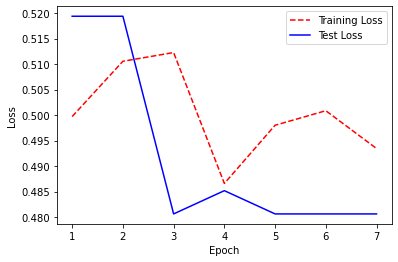

In [50]:
# Get training and test loss histories
training_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();